In [82]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import copy

In [83]:
class SARSA:
    def __init__(self, env, start_state, gamma=0.8, alpha=0.1, epsilon=0.5):
        #初始化行为值函数
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.qvalue = np.zeros((self.state_size, self.action_size))

        #初始化每个状态-动作对的次数
        self.C = np.zeros((self.state_size,self.action_size))
        self.states = []    # 状态空间500
        for i in range(self.state_size):
            self.states.append(i)

        self.actions = []   # 动作空间6
        for i in range(self.action_size):
            self.actions.append(i)
        self.gamma = gamma
        self.alpha = alpha
        self.env = env
        self.epsilon = epsilon
        self.start_state = start_state
        
        #初始化采样策略
        self.behaviour_Pi = (1/self.action_size) * np.ones((self.state_size, self.action_size))
        #初始化目标策略
        self.target_Pi = np.zeros((self.state_size,self.action_size))
        for i in range(self.state_size):
            action_prob = (1/self.action_size)*np.ones((1, self.action_size)).squeeze()
            j = np.random.choice(self.actions,p=action_prob)
            # j = np.random.choice(self.actions, p=(1/self.action_size) * np.ones(1, self.action_size))
            self.target_Pi[i,j]=1
        self.Greedy_Pi = np.zeros((self.state_size,self.action_size))
        self.cur_state = 1
        self.cur_action = 0
        self.old_policy=np.ones((self.state_size,self.action_size))
        #################1.状态转移概率P(s'|s,a)模型构建#################################
        self.P_ssa = np.zeros((self.action_size, self.state_size, self.state_size))
        self.r_sa = np.zeros((self.state_size, self.action_size))

        for i in range(self.state_size):
            for j in range(self.action_size):
                next = self.env.P[i][j]
                for k in range(len(next)):
                    probability, next_state, reward, done = next[k]
                    self.P_ssa[j][i][next_state] += probability
                    # self.r_sa[i][j] += probability*(reward)
                    if reward == -1:
                        self.r_sa[i][j] += probability*(-0.1)
                    elif reward == -10:
                        self.r_sa[i][j] += probability*(-1)
                    else:
                        self.r_sa[i][j] += probability*(1000)

    #重置环境函数
    def reset(self):
        # 初始化行为值函数
        self.qvalue = np.zeros((self.state_size, self.action_size))
        # 初始化每个状态-动作对的次数
        self.C = np.zeros((self.state_size, self.action_size))
    #根据采样策略采样一个动作
    def sample_action(self,state):
        action = np.random.choice(self.actions,p=self.behaviour_Pi[state,:])
        return action
    #跟环境交互一步
    def step(self,action):
        probability, next_state, reward, done = self.env.P[self.cur_state][action][0]
        if reward == -1:
            reward = -0.1
        elif reward == -10:
            reward = -1
        else:
            reward = 1000
        return next_state,reward,done
    #############更新目标策略##########
    def update_target_policy(self):
        for i in range(self.state_size):
            self.target_Pi[i, :] = self.epsilon / self.action_size
            max_num = np.argmax(self.qvalue[i, :])
            self.target_Pi[i, max_num] = self.epsilon / self.action_size + (1 - self.epsilon)
    #############更新采样策略##########
    def update_behaviour_policy(self):
        for i in range(self.state_size):
            self.behaviour_Pi[i, :] = self.epsilon / self.action_size
            max_num = np.argmax(self.qvalue[i, :])
            self.behaviour_Pi[i, max_num] = self.epsilon / self.action_size + (1 - self.epsilon)
    #############获得贪婪策略##########
    def get_greedy_policy(self):
        for i in range(self.state_size):
            self.Greedy_Pi[i, :] = 0
            max_num = np.argmax(self.qvalue[i, :])
            self.Greedy_Pi[i, max_num] = 1
        return self.Greedy_Pi
    #SARSA强化学习算法
    def SARSA_algorithm(self):
        num = 0
        self.update_target_policy()
        self.update_behaviour_policy()
        delta =100
        delta_list = []
        q_former = copy.deepcopy(self.qvalue)
        while delta>0.01:
            self.cur_state = self.start_state
            # self.epsilon = max(self.epsilon * 0.99, 0.1)
            self.epsilon = self.epsilon*0.999
            cur_action = self.sample_action(self.cur_state)
            flag=False
            num+=1
            print("num:",num)
            state_traj=[]
            episode_num = 0
            #每采样100条轨迹，检查下值函数是否收敛
            if num%100 ==0:
                delta = np.linalg.norm(q_former-self.qvalue)
                delta_list.append(delta)
                q_former = copy.deepcopy(self.qvalue)
                # self.update_target_policy()
                # self.update_behaviour_policy()
                self.C = np.zeros((self.state_size,self.action_size))
            while flag==False and episode_num<100:
                #与环境交互一次
                next_state, reward, flag = self.step(cur_action)
                state_traj.append(self.cur_state)
                episode_num += 1
                # 策略评估
                if flag== True:
                    self.qvalue[self.cur_state,cur_action]=reward
                    break
                else:
                    next_action = self.sample_action(next_state)
                    #利用同策略得到td目标
                    td_target = reward + self.gamma*self.qvalue[next_state, next_action]
                    self.qvalue[self.cur_state,cur_action]=self.qvalue[self.cur_state,cur_action]+\
                    self.alpha*(td_target-self.qvalue[self.cur_state,cur_action])
                #策略改善
                self.update_target_policy()
                self.update_behaviour_policy()
                #环境往前推进一步
                self.cur_state = next_state
                cur_action = next_action
            print("state_traj:",state_traj)
        return delta_list

In [84]:
class Qlearning:
    def __init__(self, env, start_state, gamma=0.8, alpha=0.1,epsilon=0.5):
        #初始化行为值函数
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.qvalue = np.zeros((self.state_size, self.action_size))

        #初始化每个状态-动作对的次数
        self.C = np.zeros((self.state_size,self.action_size))
        self.states = []    # 状态空间500
        for i in range(self.state_size):
            self.states.append(i)

        self.actions = []   # 动作空间6
        for i in range(self.action_size):
            self.actions.append(i)
        self.gamma = gamma
        self.alpha = alpha
        self.env = env
        self.epsilon = epsilon
        self.start_state = start_state
        
        #初始化采样策略
        self.behaviour_Pi = (1/self.action_size) * np.ones((self.state_size, self.action_size))
        #初始化目标策略
        self.target_Pi = np.zeros((self.state_size,self.action_size))
        for i in range(self.state_size):
            action_prob = (1/self.action_size)*np.ones((1, self.action_size)).squeeze()
            j = np.random.choice(self.actions,p=action_prob)
            # j = np.random.choice(self.actions, p=(1/self.action_size) * np.ones(1, self.action_size))
            self.target_Pi[i,j]=1
        self.Greedy_Pi = np.zeros((self.state_size,self.action_size))
        self.cur_state = 1
        self.cur_action = 0
        self.old_policy=np.ones((self.state_size,self.action_size))
        #################1.状态转移概率P(s'|s,a)模型构建#################################
        self.P_ssa = np.zeros((self.action_size, self.state_size, self.state_size))
        self.r_sa = np.zeros((self.state_size, self.action_size))

        for i in range(self.state_size):
            for j in range(self.action_size):
                next = self.env.P[i][j]
                for k in range(len(next)):
                    probability, next_state, reward, done = next[k]
                    self.P_ssa[j][i][next_state] += probability
                    # self.r_sa[i][j] += probability*(reward)
                    if reward == -1:
                        self.r_sa[i][j] += probability*(-0.1)
                    elif reward == -10:
                        self.r_sa[i][j] += probability*(-1)
                    else:
                        self.r_sa[i][j] += probability*(1000)

    #重置环境函数
    def reset(self):
        # 初始化行为值函数
        self.qvalue = np.zeros((self.state_size, self.action_size))
        # 初始化每个状态-动作对的次数
        self.C = np.zeros((self.state_size, self.action_size))
    #根据采样策略采样一个动作
    def sample_action(self,state):
        action = np.random.choice(self.actions,p=self.behaviour_Pi[state,:])
        return action
    #跟环境交互一步
    def step(self,action):
        probability, next_state, reward, done = self.env.P[self.cur_state][action][0]
        if reward == -1:
            reward = -0.1
        elif reward == -10:
            reward = -1
        else:
            reward = 1000
        return next_state,reward,done
    #############更新目标策略##########
    def update_target_policy(self):
        for i in range(self.state_size):
            self.target_Pi[i, :] = 0
            max_num = np.argmax(self.qvalue[i, :])
            self.target_Pi[i, max_num] = 1
    #############更新采样策略##########
    def update_behaviour_policy(self):
        for i in range(self.state_size):
            self.behaviour_Pi[i, :] = self.epsilon / self.action_size
            max_num = np.argmax(self.qvalue[i, :])
            self.behaviour_Pi[i, max_num] = self.epsilon / self.action_size + (1 - self.epsilon)
    #############获得贪婪策略##########
    def get_greedy_policy(self):
        for i in range(self.state_size):
            self.Greedy_Pi[i, :] = 0
            max_num = np.argmax(self.qvalue[i, :])
            self.Greedy_Pi[i, max_num] = 1
        return self.Greedy_Pi
    #Q-learning强化学习算法
    def Qlearning_algorithm(self):
        num = 0
        self.update_target_policy()
        self.update_behaviour_policy()
        delta =100
        delta_list = []
        q_former = copy.deepcopy(self.qvalue)
        while delta>0.01:
            self.cur_state = self.start_state
            self.epsilon = self.epsilon * 0.999
            cur_action = self.sample_action(self.cur_state)
            flag=False
            num+=1
            print("num:",num)
            state_traj=[]
            episode_num = 0
            #每采样100条轨迹，检查下值函数是否收敛
            if num%100 ==0:
                delta = np.linalg.norm(q_former-self.qvalue)
                delta_list.append(delta)
                q_former = copy.deepcopy(self.qvalue)
                self.C = np.zeros((self.state_size,self.action_size))
            while flag==False and episode_num<100:
                #与环境交互一次
                next_state, reward, flag = self.step(cur_action)
                state_traj.append(self.cur_state)
                episode_num += 1
                # 策略评估
                if flag== True:
                    self.qvalue[self.cur_state,cur_action]=reward
                    break
                else:
                    next_action = self.sample_action(next_state)
                    #在策略评估步不同,r+self.gamma*max(q[s',:])
                    td_target = reward+np.max(self.qvalue[next_state,:])
                    self.qvalue[self.cur_state,cur_action]=self.qvalue[self.cur_state,cur_action]+\
                    self.alpha*(td_target-self.qvalue[self.cur_state,cur_action])
                #策略改善
                self.update_target_policy()
                self.update_behaviour_policy()
                #环境往前推进一步
                self.cur_state = next_state
                cur_action = next_action
            print("state_traj:",state_traj)
            # print(self.behaviour_Pi)
        return delta_list
    

In [85]:
def q_ana_evaluate(Pi,r_sa,P_ssa):
    state_size = 500
    action_size = 6
    # state_size = 16
    # action_size = 4
    P_pi = np.zeros((state_size, state_size))
    C_pi = np.zeros((state_size, 1))
    for i in range(state_size):
        # 计算pi(a|s)*p(s'|s,a)
        P_pi[i, :] = np.dot(np.expand_dims(Pi[i, :], axis=0), P_ssa[:, i, :]).squeeze()
        # 计算pi(a|s)*r(s,a)
        C_pi[i, :] = np.dot(r_sa[i, :], Pi[i, :])
    ############解析法计算值函数######################
    M = np.eye(state_size) - 0.5*P_pi
    I_M = np.linalg.inv(M)
    V = np.dot(I_M, C_pi)
    #计算行为值函数
    q_value = np.zeros((state_size, action_size))
    for i in range(state_size):
        q_sa = np.zeros((1, action_size))
        for j in range(action_size):
            Pi[i, :] = 0
            Pi[i, j] = 1
            P_pi[i, :] = np.dot(np.expand_dims(Pi[i, :], axis=0), P_ssa[:, i, :]).squeeze()
            vi = np.dot(r_sa[i, :], Pi[i, :]) + np.dot(P_pi[i, :], V.squeeze())
            q_sa[0, j] = vi
        q_value[i, :] = q_sa[0, :]
    return q_value


In [86]:
# env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="rgb_array_list")
sarsa_env = gym.make('Taxi-v3', render_mode="rgb_array_list")
qlearning_env = gym.make('Taxi-v3', render_mode="rgb_array_list")
# state = sarsa_env.reset()[0]
state = sarsa_env.reset(seed=42, options={})[0]
qlearning_env.reset(seed=42, options={})

(386, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})

In [87]:
sarsa = SARSA(env=sarsa_env, start_state = state, gamma=0.5, alpha=0.1, epsilon=0.5)
sarsa_delta = sarsa.SARSA_algorithm()

print(sarsa.get_greedy_policy())
print("估计值函数：\n",np.around(sarsa.qvalue,2))
print("最优epsilon-greedy策略:\n",np.around(sarsa.target_Pi,2))


num: 1
state_traj: [386, 486, 486, 386, 386, 286, 386, 386, 386, 366, 266, 366, 366, 386, 386, 486, 466, 466, 466, 366, 466, 466, 486, 486, 486, 486, 486, 486, 486, 386, 386, 386, 286, 186, 186, 86, 186, 186, 286, 286, 286, 286, 286, 266, 266, 246, 346, 326, 426, 426, 426, 326, 426, 426, 426, 426, 426, 446, 446, 346, 346, 346, 346, 446, 346, 246, 266, 266, 246, 146, 246, 226, 126, 26, 26, 6, 106, 206, 206, 306, 306, 406, 406, 406, 406, 406, 406, 306, 206, 106, 6, 106, 126, 26, 6, 6, 6, 6, 6, 26]
num: 2
state_traj: [386, 366, 466, 466, 466, 466, 466, 466, 466, 366, 266, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 266, 366, 366, 386, 486, 466, 486, 486, 386, 286, 186, 166, 166, 166, 266, 266, 286, 286, 286, 266, 246, 246, 346, 326, 226, 326, 346, 346, 346, 346, 246, 246, 246, 146, 146, 46, 146, 46, 46, 46, 146, 166, 146, 146, 46, 66, 66, 86, 86, 86, 86, 86, 98, 198, 298, 398, 498, 498, 498, 398, 398, 298, 198, 98, 98, 98, 98, 98, 78, 178, 278, 378, 478, 478, 478, 378, 278, 298, 298

In [88]:
qlearning = Qlearning(env=qlearning_env, start_state = state, gamma=0.5, alpha=0.5, epsilon=0.5)
qlearning_delta = qlearning.Qlearning_algorithm()

print(qlearning.get_greedy_policy())
print("估计值函数：\n",np.around(qlearning.qvalue,2))
print("最优epsilon-greedy策略:\n",np.around(qlearning.target_Pi,2))

num: 1
state_traj: [386, 486, 486, 486, 486, 386, 286, 386, 386, 386, 366, 466, 466, 466, 466, 466, 486, 466, 466, 366, 386, 386, 386, 386, 486, 486, 486, 486, 386, 286, 186, 186, 186, 286, 286, 266, 366, 366, 366, 466, 466, 466, 466, 486, 386, 386, 366, 266, 166, 66, 66, 166, 166, 266, 266, 166, 186, 86, 186, 166, 146, 246, 346, 446, 446, 446, 346, 326, 426, 426, 426, 426, 326, 326, 326, 346, 346, 246, 146, 46, 46, 146, 166, 186, 86, 86, 86, 66, 66, 166, 166, 166, 146, 146, 146, 146, 146, 146, 246, 266]
num: 2
state_traj: [386, 486, 486, 486, 486, 466, 466, 366, 386, 286, 286, 286, 286, 286, 286, 386, 386, 386, 366, 366, 366, 266, 166, 266, 246, 226, 326, 326, 326, 346, 346, 346, 346, 246, 246, 246, 246, 246, 146, 46, 46, 46, 66, 86, 86, 66, 46, 46, 46, 146, 166, 66, 66, 66, 66, 66, 86, 98, 78, 78, 98, 198, 198, 298, 398, 498, 498, 498, 398, 378, 278, 378, 398, 298, 298, 398, 398, 378, 378, 398, 378, 398, 398, 298, 198, 98, 98, 98, 78, 98, 98, 98, 86, 186, 186, 186, 86, 86, 98, 98]
nu

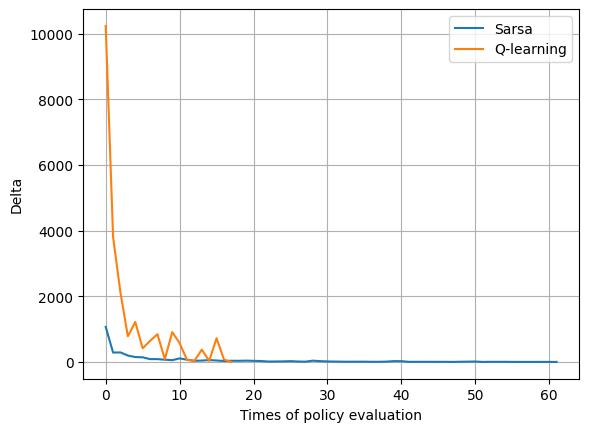

In [89]:
plt.plot(sarsa_delta, label="Sarsa")
plt.plot(qlearning_delta,label="Q-learning")
plt.legend()
plt.grid(True)
plt.xlabel("Times of policy evaluation")
plt.ylabel("Delta")
plt.show()

In [91]:
sarsa_greedy_action = np.argmax(sarsa.target_Pi, axis=1)
qlearning_greedy_action = np.argmax(qlearning.target_Pi, axis=1)

In [92]:
sarsa_state = state
qlearning_state = state

In [93]:
sarsa_frame = []
sarsa_action_list = []
print(sarsa_state)
# 循环交互
while True:
    # 按照策略选取动作
    sarsa_action = sarsa_greedy_action[sarsa_state]
    print("state:", sarsa_state)
    print("action:", sarsa_action)
    sarsa_action_list.append(sarsa_action)

    # agent与环境进行一步交互
    sarsa_state, reward, sarsa_terminated, truncated, info = sarsa_env.step(sarsa_action)

    # 判断当前否完成
    if sarsa_terminated:
        print('done')
        break
    # time.sleep(1)
    
sarsa_frame.append(sarsa_env.render())
sarsa_env.close()

386
state: 386
action: 1
state: 286
action: 1
state: 186
action: 1
state: 86
action: 4
state: 98
action: 0
state: 198
action: 3
state: 178
action: 0
state: 278
action: 3
state: 258
action: 3
state: 238
action: 3
state: 218
action: 0
state: 318
action: 0
state: 418
action: 5
done


In [94]:
qlearning_frame = []
qlearning_action_list = []
print(qlearning_state)
# 循环交互
while True:
    # 按照策略选取动作
    qlearning_action = qlearning_greedy_action[qlearning_state]
    print("state:", qlearning_state)
    print("action:", qlearning_action)
    qlearning_action_list.append(qlearning_action)

    # agent与环境进行一步交互
    qlearning_state, reward, qlearning_terminated, truncated, info = qlearning_env.step(qlearning_action)

    # 判断当前否完成
    if qlearning_terminated:
        print('done')
        break
    # time.sleep(1)
    
qlearning_frame.append(qlearning_env.render())
qlearning_env.close()

386
state: 386
action: 1
state: 286
action: 1
state: 186
action: 1
state: 86
action: 4
state: 98
action: 0
state: 198
action: 0
state: 298
action: 3
state: 278
action: 3
state: 258
action: 3
state: 238
action: 3
state: 218
action: 0
state: 318
action: 0
state: 418
action: 5
done


In [32]:
sarsa_frames = np.array(sarsa_frame)
sarsa_frames = sarsa_frames.squeeze()
len(sarsa_frames[0])

qlearning_frames = np.array(qlearning_frame)
qlearning_frames = qlearning_frames.squeeze()
len(qlearning_frames[0])

350

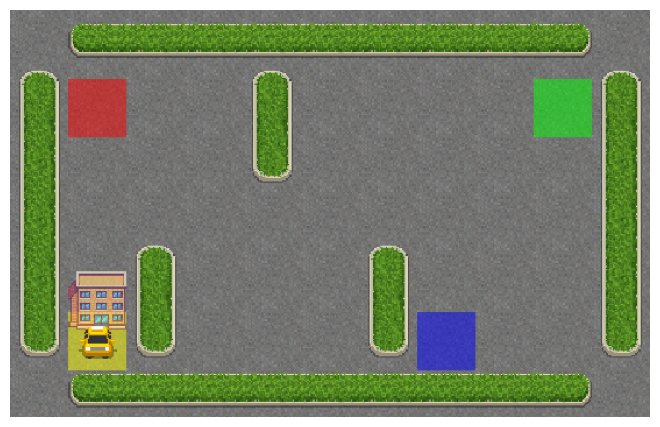

In [33]:
import os
for i in range(sarsa_frames.shape[0] - 1):
    plt.imshow(sarsa_frames[i])
    # plt.title('action = {0}'.format(num_to_actual[action_list[i]]), fontsize=22)
    # 去除坐标轴
    plt.axis('off')
    
    # 去除周围的白边
    plt.tight_layout(pad=0)
    plt.savefig(os.path.join('./result/Sarsa', 'frame_{0}.png'.format(i)))
    # plt.show()

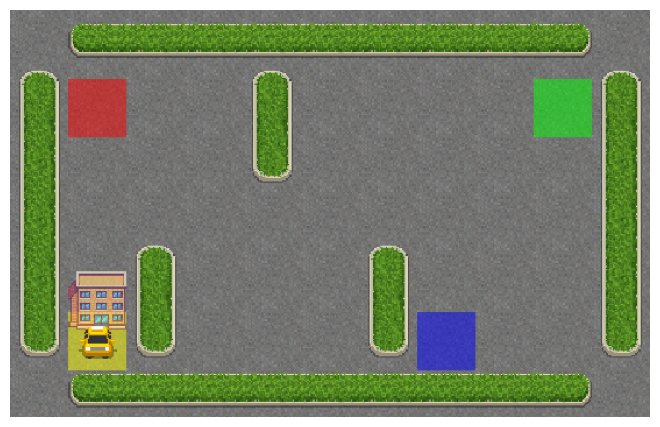

In [34]:
for i in range(qlearning_frames.shape[0] - 1):
    plt.imshow(qlearning_frames[i])
    # plt.title('action = {0}'.format(num_to_actual[action_list[i]]), fontsize=22)
    # 去除坐标轴
    plt.axis('off')
    
    # 去除周围的白边
    plt.tight_layout(pad=0)
    plt.savefig(os.path.join('./result/Q-learning', 'frame_{0}.png'.format(i)))
    # plt.show()

In [36]:
import imageio

imageio.mimsave("result/Sarsa/sarsa.gif", sarsa_frames, duration=500)
imageio.mimsave("result/Q-learning/qlearning.gif", qlearning_frames, duration=500)